In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

### Load modules

In [ ]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.2


# Import Data from Sheets or BigQuery

## From Sheets

In [ ]:
#@title Parameters

#INPUT_SHEET_NAME = 'uncleaned data' #@param {type:"string"}

In [ ]:
'''
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')
'''

"\nworksheet = gc.open(INPUT_SHEET_NAME).sheet1\n\n# get_all_values gives a list of rows.\nrows = worksheet.get_all_values()\n\ndf=pd.DataFrame.from_records(rows)\n\n\n#get column names from first row\ndf.columns = df.iloc[0]\n\n#drop row with column names\ndf = df.drop(df.index[0])\n\n#reset indexes\ndf = df.reset_index(drop=True)\n\n#convert numeric data to numeric types\ndf = df.apply(pd.to_numeric, errors='ignore')\n"

## From BigQuery

In [ ]:
%%bigquery df
SELECT *
FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`
WHERE Division IS NOT NULL;

In [ ]:
df.head()

,Division,day,total_clicks,NonBrand_clicks,Brand_clicks,Brand_x_RMKT_x_EC_clicks,Brand_x_Core_x_NC_clicks,NonBrand_x_Core_x_NC_clicks,Brand_x_RMKT_x_NCFM_clicks,NonBrand_x_RMKT_x_NCFM_clicks,BingYahoo_clicks,Google_clicks,Google_div_BingYahoo_ratio,core_clicks,rmkt_clicks,top_clicks,LOB_other_clicks,LOB_top_div_other_ratio,keyword_comcast_clicks,keyword_xfinity_clicks,keyword_other_clicks,exact_clicks,match_type_other_clicks,search_mobile_clicks,search_desktop_clicks,search_mobile_div_desktop_ratio,search_NC_clicks,search_EC_clicks,search_other_audience_clicks,core_x_xfinity_clicks,core_x_comcast_clicks,core_x_other_keyword_clicks,rmkt_x_xfinity_clicks,rmkt_x_comcast_clicks,rmkt_x_other_keyword_clicks,core_x_NC_clicks,core_x_EC_clicks,core_x_Audience_Other_clicks,rmkt_x_NC_clicks,rmkt_x_EC_clicks,rmkt_x_Audience_Other_clicks,NC_x_xfinity_clicks,EC_x_xfinity_clicks,Audience_Other_x_xfinity_clicks,NC_x_comcast_clicks,EC_x_comcast_clicks,Audience_Other_x_comcast_clicks,NC_x_keyword_other,EC_x_keyword_other,Audience_Other_x_keyword_other,tactic_Core_x_keyword_xfinity_x_audience_NC,tactic_Core_x_keyword_xfinity_x_audience_EC,tactic_Core_x_keyword_xfinity_x_audience_other,tactic_Core_x_keyword_comcast_x_audience_NC,tactic_Core_x_keyword_comcast_x_audience_EC,tactic_Core_x_keyword_comcast_x_audience_other,tactic_Core_x_keyword_other_x_audience_NC,tactic_Core_x_keyword_other_x_audience_EC,tactic_Core_x_keyword_other_x_audience_other,tactic_RMKT_x_keyword_xfinity_x_audience_NC,tactic_RMKT_x_keyword_xfinity_x_audience_EC,tactic_RMKT_x_keyword_xfinity_x_audience_other,tactic_RMKT_x_keyword_comcast_x_audience_NC,tactic_RMKT_x_keyword_comcast_x_audience_EC,tactic_RMKT_x_keyword_comcast_x_audience_other,tactic_RMKT_x_keyword_other_x_audience_NC,tactic_RMKT_x_keyword_other_x_audience_EC,tactic_RMKT_x_keyword_other_x_audience_other,Division_x,total_imps,AOL_div_Amazon_imps_ratio,Oath_div_Rocketfuel_imps_ratio,Oath_div_Amazon_imps_ratio,Oath_div_DBM_imps_ratio,Oath_div_TTD_imps_ratio,Oath_div_OTHER_imps_ratio,DBM_imps,Rocketfuel_imps,Amazon_imps,Oath_imps,OTHER_imps,Pandora_imps,TTD_imps,Display_imps,Audio_imps,Video_imps,Social_imps,Desktop_imps,Mobile_imps,desktop_div_mobile_imps,ACQ_imps,AWA_imps,RTG_imps,Display_x_ACQ_imps,Display_x_AWA_imps,Display_x_RTG_imps,Audio_x_ACQ_imps,Audio_x_AWA_imps,Audio_x_RTG_imps,Social_x_ACQ_imps,Social_x_AWA_imps,Social_x_RTG_imps,Video_x_ACQ_imps,Video_x_AWA_imps,Video_x_RTG_imps,Desktop_x_ACQ_imps,Desktop_x_AWA_imps,Desktop_x_RTG_imps,Mobile_x_ACQ_imps,Mobile_x_AWA_imps,Mobile_x_RTG_imps,OTHER_x_Video_x_AWA_imps,Oath_x_Display_x_AWA_imps,Oath_x_Video_x_AWA_imps,Oath_x_Audio_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,Oath_x_Audio_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,OTHER_x_Display_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,OTHER_x_Audio_x_AWA_imps,OTHER2_x_Audio_x_AWA_imps,OTHER_x_Audio_x_ACQ_imps,Pandora_x_Audio_x_ACQ_imps,The_Trade_Desk_x_Video_x_ACQ_imps,Rocketfuel_x_Video_x_ACQ_imps,Amazon_x_Display_x_ACQ_imps,DBM_x_Audio_x_AWA_imps,OTHER_x_Social_x_ACQ_imps,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,OTHER_x_Display_x_RTG_imps,OTHER_x_Video_x_ACQ_imps,Pandora_x_Video_x_ACQ_imps,Pandora_x_Display_x_ACQ_imps,The_Trade_Desk_x_Video_x_AWA_imps,Pandora_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Rocketfuel_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_ACQ_imps,Pandora_x_Audio_x_AWA_imps,Oath_x_Display_x_ACQ_imps,Rocketfuel_x_Display_x_AWA_imps,Rocketfuel_x_Display_x_ACQ_imps,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_ACQ_imps,Pandora_x_Display_x_AWA_imps,OTHER_x_Social_x_AWA_imps,The_Trade_Desk_x_Display_x_ACQ_imps,Oath_x_Video_x_ACQ_imps,Division_y,new_accounts,national_imps,national_clicks,__index_level_0__
0,Northeast,2019-03-25 00:00:00+00:00,36583,3336.00000,28423,5585,17067,2936.00000,5771,384.00000,4824,31759,6.58354,20003,11756,24316,12267,1.98223,12059,16076,8448,25185,None,18756,17827,1.05211,26158,5601,None,9601,7178

# Data Cleaning

Keep only necessary columns

In [ ]:
df = df [['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
          'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
          'DBM_x_Video_x_AWA_imps','national_clicks','The_Trade_Desk_x_Audio_x_AWA_imps',
          'OTHER_x_Display_x_AWA_imps','Oath_x_Display_x_AWA_imps','Pandora_x_Audio_x_ACQ_imps',
          'Oath_x_Audio_x_AWA_imps','Pandora_x_Video_x_ACQ_imps','Amazon_x_Display_x_RTG_imps',
          'Brand_x_RMKT_x_EC_clicks','DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
          'DBM_x_Display_x_ACQ_imps','Amazon_x_Video_x_AWA_imps','DBM_x_Social_x_AWA_imps',
          'Oath_x_Video_x_ACQ_imps','new_accounts', 'day']]

In [ ]:
df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts,day
0,17067,nan,334023.00000,1735596.00000,1826161.00000,2098,209733.00000,2653645.00000,nan,26265.00000,nan,nan,3198766.00000,5585,8400476.00000,nan,18284479.00000,39736.00000,nan,nan,1653,2019-03-25 00:00:00+00:00
1,13398,nan,801902.00000,1270805.00000,272857.00000,1351,158747.00000,7165284.00000,nan,45691.00000,nan,44125.00000,2144522.00000,3807,2464305.00000,10013.00000,4041579.00000,21794.00000,14818.00000,nan,1466,2018-11-29 00:00:00+00:00
2,9109,nan,631746.00000,1373478.00000,126028.00000,1120,103955.00000,6705270.00000,nan,18706.00000,nan,18161.00000,2357421.00000,2744,1292850.00000,4091.00000,4331451.00000,3959.00000,18102.00000,nan,604,2018-11-22 00:00:00+00:00
3,10787,nan,1522130.00000,1639503.00000,287042.00000,1157,166883.00000,9191794.00000,nan,25406.00000,nan,24560.00000,2792468.00000,3111,2702506.00000,2823.00000,3944924.00000,10078.00000,17707.00000,nan,891,2018-12-09 00:00:00+00:00
4,12781,nan,341272.00000,1369087.00000,1552542.00000,1665,197307.00000,477541.00000,nan,25011.00000,nan,nan,663885.00000,4211,5689437.00000,nan,13782058.00000,26261.00000,nan,nan,1023,2019-03-30 00:00:00+00:00


## Step 1: Handling Missing Data

In [ ]:
# Determine number of missing values
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

Oath_x_Video_x_ACQ_imps               97.19934
Pandora_x_Video_x_ACQ_imps            87.80890
Oath_x_Audio_x_AWA_imps               84.51400
The_Trade_Desk_x_Display_x_AWA_imps   75.28830
Pandora_x_Audio_x_ACQ_imps            75.28830
OTHER_x_Display_x_ACQ_imps            59.96705
DBM_x_Social_x_AWA_imps               57.99012
Amazon_x_Display_x_RTG_imps           51.72982
Oath_x_Display_x_AWA_imps             49.58814
The_Trade_Desk_x_Audio_x_AWA_imps     34.92586
Amazon_x_Video_x_AWA_imps             23.55848
DBM_x_Video_x_AWA_imps                21.58155
Amazon_x_Display_x_AWA_imps           11.53213
DBM_x_Display_x_ACQ_imps              6.58979 
DBM_x_Display_x_AWA_imps              5.76606 
DBM_x_Display_x_RTG_imps              0.00000 
day                                   0.00000 
national_clicks                       0.00000 
OTHER_x_Display_x_AWA_imps            0.00000 
new_accounts                          0.00000 
Brand_x_RMKT_x_EC_clicks              0.00000 
Brand_x_Core_

In [ ]:
# Determine percent of zeros by column
num_zeros = (100*df[df == 0].count(axis=0)/len(df.index))
num_zeros.sort_values(ascending = False)

OTHER_x_Display_x_ACQ_imps            4.28336
DBM_x_Video_x_AWA_imps                1.31796
Pandora_x_Audio_x_ACQ_imps            0.65898
Oath_x_Video_x_ACQ_imps               0.32949
Amazon_x_Video_x_AWA_imps             0.32949
DBM_x_Display_x_ACQ_imps              0.16474
Amazon_x_Display_x_AWA_imps           0.16474
day                                   0.00000
OTHER_x_Display_x_AWA_imps            0.00000
The_Trade_Desk_x_Display_x_AWA_imps   0.00000
DBM_x_Display_x_RTG_imps              0.00000
national_clicks                       0.00000
The_Trade_Desk_x_Audio_x_AWA_imps     0.00000
Oath_x_Audio_x_AWA_imps               0.00000
Oath_x_Display_x_AWA_imps             0.00000
new_accounts                          0.00000
Pandora_x_Video_x_ACQ_imps            0.00000
Amazon_x_Display_x_RTG_imps           0.00000
Brand_x_RMKT_x_EC_clicks              0.00000
DBM_x_Display_x_AWA_imps              0.00000
DBM_x_Social_x_AWA_imps               0.00000
Brand_x_Core_x_NC_clicks          

### Option to drop columns with high percentage of missing data

In [ ]:
#@title Set threshold for missing data

remove_missing_vals = "No" #@param {type: "string"}
missing_value_threshold = 50 #@param {type:"integer"}


In [ ]:
missing_value_threshold = 50
missing_value_threshold_cols = []

if remove_missing_vals == "Yes":
  for i in missing_values[missing_values >= missing_value_threshold].index:
    missing_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

No columns dropped
Remaining columns: Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'national_clicks',
       'The_Trade_Desk_x_Audio_x_AWA_imps', 'OTHER_x_Display_x_AWA_imps',
       'Oath_x_Display_x_AWA_imps', 'Pandora_x_Audio_x_ACQ_imps',
       'Oath_x_Audio_x_AWA_imps', 'Pandora_x_Video_x_ACQ_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'Amazon_x_Video_x_AWA_imps',
       'DBM_x_Social_x_AWA_imps', 'Oath_x_Video_x_ACQ_imps', 'new_accounts',
       'day'],
      dtype='object')


### Imputing Missing Data

In [ ]:
#@title Define Imputation Method

# Imputation Method: Mean value, Median Value, Zero
imputation_method = 'mean value' #@param {type:"string"}


In [ ]:
if imputation_method == 'mean value':
  df.fillna(df.mean(), inplace = True)
elif imputation_method == 'median value':
  df.fillna(df.median(), inplace = True)
else:
  df.fillna(0, inplace = True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


### Identify & drop columns with all 0's 


Constant variance violates model assumptions

The goal of printing the null_list below is to check alignment with the media buy.

In [ ]:
# Identify columns with all 0's
col_nulls = df.loc[:, (df == 0).all()]
null_list = list(col_nulls.columns) 
null_list # check alignment with media buy 

# Drop columns with all 0's
df.drop(null_list, axis=1, inplace=True)
print("Columns dropped")

Columns dropped


## Step 2: Define date and Y (KPI column), create initial feature set

In [ ]:
#@title Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

DATE_COL = "day" #@param {type: "string"}
KPI_COL = "new_accounts" #@param {type: "string"}


In [ ]:
cols = [col for col in df.columns]
featureset_df = df[cols]
featureset_df = featureset_df.loc[:, (featureset_df != 0).any(axis=0)]

#Feature Selection

Note: A **max of 50 features** is recommended for 24 months of data due to risk of overfitting. 

1. **Step 1**: run correlation analysis & output pos/neg coefficients above specified threshold

2. **Step 2**: run variance inflation factor analysis & output results to flag multicollinearity above specified threshold 

3. checkpoint to update the INITIAL design of features if multicollinearity is an issue

4. **Step 3**: perform multivariate testing to FINALIZE feature selection / data reduction (see optional section below for advanced feature selection if you have more than 50 inputs)
 


## Step 1: Run correlation analysis & filter to positive coefficients > the specified threshold

In [ ]:
#@title Input correlation threshold for output (must be between 0 and 1)

THRESHOLD_1 =  .6 #@param {type: "number"}

In [ ]:
correl = df.corr()
correl

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts
Brand_x_Core_x_NC_clicks,1.00000,0.08631,0.12738,0.07583,0.10946,0.37791,-0.02424,-0.10055,0.10969,-0.00681,-0.06655,0.01458,0.04379,0.44381,0.05848,0.00501,0.00708,0.03662,0.06179,-0.01672,0.68340
The_Trade_Desk_x_Display_x_AWA_imps,0.08631,1.00000,0.00458,0.06986,0.14595,0.07550,-0.11881,0.04731,0.01188,0.00176,0.15250,0.00000,0.06032,-0.13860,0.07035,-0.29134,0.03105,0.19099,-0.10298,-0.00000,0.27269
Amazon_x_Display_x_AWA_imps,0.12738,0.00458,1.00000,0.12440,0.16889,-0.08733,-0.25258,0.01682,-0.04114,0.11069,-0.05263,-0.03274,-0.13106,0.04471,-0.09910,-0.04601,-0.18965,-0.01989,-0.26001,0.02270,0.25114
DBM_x_Display_x_RTG_imps,0.07583,0.06986,0.12440,1.00000,0.06443,0.20930,-0.00179,0.16185,0.14210,0.11064,-0.31014,0.01981,0.10943,-0.30652,0.13437,0.16105,0.14425,0.04547,-0.11301,0.01052,0.25310
DBM_x_Video_x_AWA_imps,0.10946,0.14595,0.16889,0.06443,1.00000,0.24154,0.05089,0.11069,-0.11667,-0.09740,-0.01499,-0.00666,0.14339,-0.22196,0.50480,-0.00590,0.50403,-0.03323,0.00009,-0.01442,0.22185
national_clicks,0.37791,0.07550,-0.08733,0.20930,0.24154,1.00000,0.37241,0.04809,0.02800,-0.05009,-0.13691,-0.03939,0.30562,0.09279,0.33816,0.03241,0.46407,0.04350,0.10348,-0.02547,0.21362
The_Trade_Desk_x_Audio_x_AWA_imps,-0.02424,-0.11881,-0.25258,-0.00179,0.05089,0.37241,1.00000,0.18113,0.01365,-0.02026,-0.00000,0.00915,0.27011,-0.06515,0.60969,0.01543,0.65237,-0.06013,0.10821,0.00609,-0.33259
OTHER_x_Display_x_AWA_imps,-0.10055,0.04731,0.01682,0.16185,0.11069,0.04809,0.18113,1.00000,-0.04926,0.00857,-0.00912,-0.02462,0.33472,-0.51515,0.47253,-0.27137,0.39213,-0.07316,-0.39957,-0.05601,-0.17060
Oath_x_Display_x_AWA_imps,0.10969,0.01188,-0.04114,0.14210,-0.11667,0.02800,0.01365,-0.04926,1.00000,-0.00114,0.20612,-0.00386,0.05105,0.08189,-0.06189,-0.05112,-0.08546,-0.01221,-0.11766,-0.04366,0.15739
Pandora_x_Audio_x_ACQ_imps,-0.00681,0.00176,0.11069,0.11064,-0.09740,-0.05009,-0.02026,0.00857,-0.00114,1.00000,-0.04400,0.58655,-0.06243,0.01541,-0.08157,-0.00951,-0.12349,-0.00107,-0.03387,0.00000,-0.00720


In [ ]:
# output correlations > threshold_1 to review for data reduction

corrs_pos = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_pos = corrs_pos[corrs_pos > THRESHOLD_1].stack().reset_index() # user defines threshold and can increase to be more conservative
corrs_pos = corrs_pos.loc[corrs_pos[0]<1.0]
corrs_pos

,level_0,level_1,0
1,Brand_x_Core_x_NC_clicks,new_accounts,0.68340
8,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_AWA_imps,0.60969
9,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_ACQ_imps,0.65237
18,DBM_x_Display_x_AWA_imps,DBM_x_Display_x_ACQ_imps,0.83807


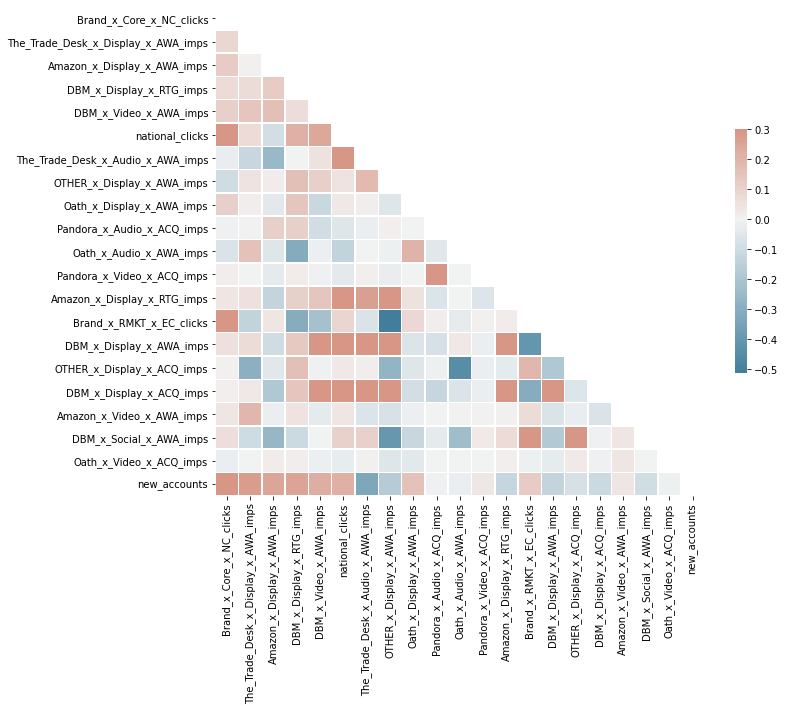

In [ ]:
mask = np.triu(np.ones_like(correl, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correl, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#@title Input 2nd correlation threshold (must be between -1 and 0)
THRESHOLD_2 =  -.6 #@param {type: "number"}

In [ ]:
# feature reduction 1B: output correlations < threshold_2 to review for data reduction 
corrs_neg = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_neg = corrs_neg[corrs_neg < THRESHOLD_2].stack().reset_index() # user defines threshold and can decrease to be more conservative
corrs_neg = corrs_neg.loc[corrs_neg[0]<1.0]
corrs_neg

,level_0,level_1,0


## Step 2: Check for Multicollinearity


Run variance inflation factor (VIF) analysis & review values > 7 

Notes: 
*   Industry best practice flags values > 10 as a violation of regression model assumptions

In [ ]:
featureset_df.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Display_x_AWA_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Display_x_RTG_imps,DBM_x_Video_x_AWA_imps,national_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,OTHER_x_Display_x_AWA_imps,Oath_x_Display_x_AWA_imps,Pandora_x_Audio_x_ACQ_imps,Oath_x_Audio_x_AWA_imps,Pandora_x_Video_x_ACQ_imps,Amazon_x_Display_x_RTG_imps,Brand_x_RMKT_x_EC_clicks,DBM_x_Display_x_AWA_imps,OTHER_x_Display_x_ACQ_imps,DBM_x_Display_x_ACQ_imps,Amazon_x_Video_x_AWA_imps,DBM_x_Social_x_AWA_imps,Oath_x_Video_x_ACQ_imps,new_accounts,day
0,17067,90717.64667,334023.00000,1735596.00000,1826161.00000,2098,209733.00000,2653645.00000,130004.89869,26265.00000,94597.06383,31748.60811,3198766.00000,5585,8400476.00000,145711.62963,18284479.00000,39736.00000,26520.93333,98568.52941,1653,2019-03-25 00:00:00+00:00
1,13398,90717.64667,801902.00000,1270805.00000,272857.00000,1351,158747.00000,7165284.00000,130004.89869,45691.00000,94597.06383,44125.00000,2144522.00000,3807,2464305.00000,10013.00000,4041579.00000,21794.00000,14818.00000,98568.52941,1466,2018-11-29 00:00:00+00:00
2,9109,90717.64667,631746.00000,1373478.00000,126028.00000,1120,103955.00000,6705270.00000,130004.89869,18706.00000,94597.06383,18161.00000,2357421.00000,2744,1292850.00000,4091.00000,4331451.00000,3959.00000,18102.00000,98568.52941,604,2018-11-22 00:00:00+00:00
3,10787,90717.64667,1522130.00000,1639503.00000,287042.00000,1157,166883.00000,9191794.00000,130004.89869,25406.00000,94597.06383,24560.00000,2792468.00000,3111,2702506.00000,2823.00000,3944924.00000,10078.00000,17707.00000,98568.52941,891,2018-12-09 00:00:00+00:00
4,12781,90717.64667,341272.00000,1369087.00000,1552542.00000,1665,197307.00000,477541.00000,130004.89869,25011.00000,94597.06383,31748.60811,663885.00000,4211,5689437.00000,145711.62963,13782058.00000,26261.00000,26520.93333,98568.52941,1023,2019-03-30 00:00:00+00:00


In [ ]:
vif = add_constant(featureset_df.drop(columns=[DATE_COL, KPI_COL]))

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 
print(vif.sort_values(ascending=False))

const                                 377.35681
DBM_x_Display_x_ACQ_imps              5.98983  
DBM_x_Display_x_AWA_imps              5.36815  
Brand_x_RMKT_x_EC_clicks              3.12181  
The_Trade_Desk_x_Audio_x_AWA_imps     2.84360  
DBM_x_Video_x_AWA_imps                2.23768  
DBM_x_Social_x_AWA_imps               2.18840  
OTHER_x_Display_x_AWA_imps            2.08336  
OTHER_x_Display_x_ACQ_imps            1.91618  
Brand_x_Core_x_NC_clicks              1.88913  
national_clicks                       1.76198  
Pandora_x_Audio_x_ACQ_imps            1.65936  
Amazon_x_Display_x_RTG_imps           1.65216  
DBM_x_Display_x_RTG_imps              1.62685  
Pandora_x_Video_x_ACQ_imps            1.58690  
Oath_x_Audio_x_AWA_imps               1.52064  
Amazon_x_Display_x_AWA_imps           1.41836  
The_Trade_Desk_x_Display_x_AWA_imps   1.26217  
Oath_x_Display_x_AWA_imps             1.19975  
Amazon_x_Video_x_AWA_imps             1.06585  
Oath_x_Video_x_ACQ_imps               1.

In [ ]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [ ]:
vif_df

,feature,vif
0,const,377.35681
17,DBM_x_Display_x_ACQ_imps,5.98983
15,DBM_x_Display_x_AWA_imps,5.36815
14,Brand_x_RMKT_x_EC_clicks,3.12181
7,The_Trade_Desk_x_Audio_x_AWA_imps,2.84360
5,DBM_x_Video_x_AWA_imps,2.23768
19,DBM_x_Social_x_AWA_imps,2.18840
8,OTHER_x_Display_x_AWA_imps,2.08336
16,OTHER_x_Display_x_ACQ_imps,1.91618
1,Brand_x_Core_x_NC_clicks,1.88913


## Step 3: Feature Transformation

Test transformations to evaluate the impact of diminishing returns

Notes:
* SQRT and log can both be tested
* In our tests, application of SQRT function outperformed log


In [ ]:
#@title Input transformation type (ex: log, sqrt)
transformation = 'Square Root' #@param ["Square Root", "Log"]

In [ ]:
X = featureset_df.drop(columns=[DATE_COL,KPI_COL])

# These transformations stabilize large values in the dataset, and allow the data to be more normal
if transformation == "Square Root":
  X_transform = X.apply(np.sqrt)

else: 
  X += 1 # natural log function is not defined at 0 so need to add 1 to each value 
  X_transform = X.apply(np.log)

### Standardize Features

Puts data on the same scale and optimizes performance and interpretability

In [ ]:
standardized_transform = StandardScaler().fit_transform(X_transform) 
X_transform_stand=pd.DataFrame(standardized_transform, columns=X.columns) 

###Run regression results to review p-values for data reduction only

In [ ]:
# add column of 1's to estimate intercept parameter
X_transform_stand = sm.add_constant(X_transform_stand) 

# define Y
Y = featureset_df[[KPI_COL]]

# run OLS model using statsmodels package for p-values
model = sm.OLS(Y, X_transform_stand)
results = model.fit()
predictions = model.predict(results.params) 

print_model = results.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           new_accounts   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     85.14
Date:                Tue, 17 Aug 2021   Prob (F-statistic):          1.51e-158
Time:                        14:02:38   Log-Likelihood:                -4168.4
No. Observations:                 607   AIC:                             8379.
Df Residuals:                     586   BIC:                             8471.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                1500.7628      9.598    156.355      0.000    1481.911    1519.614
Brand_x_Core_x_NC_clicks              349.3998     13.941     25.063      0.000     322.020     376.780
The_Trade_Desk_x_Display_x_AWA_imps    47.9325     10.524      4.554      0.000      27.263      68.602
Amazon_x_Display_x_AWA_imps            29.7719     11.730      2.538      0.011       6.735      52.809
DBM_x_Display_x_RTG_imps               85.6789     13.278      6.453      0.000      59.600     111.758
DBM_x_Video_x_AWA_imps                 60.4536     12.749      4.742      0.000      35.414      85.493
national_clicks                        -2.2091     12.644     -0.175      0.861     -27.043      22.625
The_Trade_Desk_x_Audio_x_AWA_imps    -121.7976     14.633     -8.324      0.000    -150.537     -93.058
OTHER_x_Display_x_AWA_imps            -83.7138     14.048     -5.959      0.000    -111.305     -56.123
Oath_x_Display_x_AWA_imps              28.0220     10.444      2.683      0.008       7.510      48.534
Pandora_x_Audio_x_ACQ_imps            -10.6986     10.947     -0.977      0.329     -32.198      10.801
Oath_x_Audio_x_AWA_imps                11.0902     11.075      1.001      0.317     -10.662      32.842
Pandora_x_Video_x_ACQ_imps             14.4675     10.649      1.359      0.175      -6.447      35.382
Amazon_x_Display_x_RTG_imps           -32.0891     11.152     -2.877      0.004     -53.992     -10.187
Brand_x_RMKT_x_EC_clicks             -102.1464     20.490     -4.985      0.000    -142.390     -61.903
DBM_x_Display_x_AWA_imps             -155.5733     19.821     -7.849      0.000    -194.503    -116.643
OTHER_x_Display_x_ACQ_imps            -58.6047     12.517     -4.682      0.000     -83.189     -34.021
DBM_x_Display_x_ACQ_imps              114.5991     19.220      5.962      0.000      76.850     152.348
Amazon_x_Video_x_AWA_imps             -24.0178     10.942     -2.195      0.029     -45.509      -2.527
DBM_x_Social_x_AWA_imps                -5.7199     14.301     -0.400      0.689     -33.807      22.367
Oath_x_Video_x_ACQ_imps                 3.6221      9.723      0.373      0.710     -15.474      22.718
==============================================================================
Omnibus:                        8.767   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.351
Skew:                          -0.149   Prob(JB):                      0.00343
Kurtosis:                       3.600   Cond. No.                         5.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Implement FINAL feature selection logic based on analysis of above results

Set your p-Value threshold. This removes features with P values greater than the threshold below. For example: 
*   p-Value <= .1 / 90% significance 

In [ ]:
#@title Input p-Value threshold
P_THRESHOLD =  .1 #@param {type: "number"}

In [ ]:
# FINAL feature selection/data reduction
results_df = (results.summary2().tables[1])
sig_input = list(results_df[results_df['P>|t|']<=P_THRESHOLD].index)[1:]
X_inputs = X_transform_stand[sig_input] 
X_inputs.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_AWA_imps', 'DBM_x_Display_x_RTG_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'OTHER_x_Display_x_AWA_imps', 'Oath_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'Brand_x_RMKT_x_EC_clicks',
       'DBM_x_Display_x_AWA_imps', 'OTHER_x_Display_x_ACQ_imps',
       'DBM_x_Display_x_ACQ_imps', 'Amazon_x_Video_x_AWA_imps'],
      dtype='object')

## Steps 4 & 5 Reduce Feature Set (Optional)

Feature selection methods if > 50 inputs remain after 3-step data reduction process

In [ ]:
len(X_inputs.columns)

14

###Step 4: KBest

Top features based on univariate testing


In [ ]:
k_best = SelectKBest(f_regression, k=len(X_inputs.columns))
k_best.fit_transform(X_inputs, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 1.17395664,  0.13441864,  0.13739144, ...,  0.25577003,
         3.02038954, -0.0316522 ],
       [-0.36973432,  0.13441864,  0.83248389, ..., -1.28101765,
         0.17585522, -0.35617077],
       [-2.47505164,  0.13441864,  0.61213016, ..., -1.47801   ,
         0.26480196, -0.88776176],
       ...,
       [ 0.25439183,  0.13441864, -1.088685  , ...,  0.25577003,
         0.0292259 ,  0.34375909],
       [ 0.84826808,  0.13441864, -1.11634575, ..., -1.81927982,
        -0.29476698,  0.34375909],
       [ 0.68752169,  0.13441864, -1.10876292, ..., -1.82153987,
        -0.11033257,  0.34375909]])

###Step 5: Recursive Feature Elimination (RFE)

Rank features based on recursive model testing

In [ ]:
lm = LinearRegression()
rfe = RFE(lm, 1)
X_rfe = rfe.fit_transform(X_inputs,Y)
lm.fit(X_rfe,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Output results of optional feature selection process

In [ ]:
# create dataframe with KBest and RFE results
opt_datared_df = pd.DataFrame({'feature': X_inputs.columns, 'p_value': k_best.pvalues_, 'rfe_rank': rfe.ranking_}).sort_values('p_value')
opt_datared_df

,feature,p_value,rfe_rank
0,Brand_x_Core_x_NC_clicks,0.00000,1
5,The_Trade_Desk_x_Audio_x_AWA_imps,0.00000,2
3,DBM_x_Display_x_RTG_imps,0.00000,7
2,Amazon_x_Display_x_AWA_imps,0.00000,12
4,DBM_x_Video_x_AWA_imps,0.00000,9
1,The_Trade_Desk_x_Display_x_AWA_imps,0.00002,10
9,Brand_x_RMKT_x_EC_clicks,0.00035,3
6,OTHER_x_Display_x_AWA_imps,0.00107,6
8,Amazon_x_Display_x_RTG_imps,0.01001,11
12,DBM_x_Display_x_ACQ_imps,0.01829,5


#### Implement OPTIONAL feature selection logic based on analysis of above results
Set your p-Value threshold. For example: 
*   p-Value <= .1 / 90% significance OR
*   top 75%+ of ranking (e.g. top 15 of total 20)


In [ ]:
#@title Input p-Value and rank thresholds
P_THRESHOLD_OPT =  .1 #@param {type: "number"}
RANK_THRESHOLD =  1 #@param {type: "number"}

In [ ]:
# OPTIONAL feature selection/data reduction

opt_reduction = opt_datared_df[((opt_datared_df['p_value']<=P_THRESHOLD_OPT) | 
                             (opt_datared_df['rfe_rank'] <= RANK_THRESHOLD))] 

In [ ]:
# create list of FINAL model inputs, overwriting previous input feature list.
opt_inputs =[]   

for index, rows in opt_reduction.iterrows(): # iterate over each row 
    opt_inputs.append(rows.feature) 

X_inputs = X_inputs[opt_inputs]

# Compile Final Dataset

In [ ]:
data = X_inputs
data[KPI_COL] = Y
data.head()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
0,1.17396,0.85686,0.53833,0.13739,2.42995,0.13442,-0.17394,0.15935,2.03978,3.02039,0.14012,2.38000,1653
1,-0.36973,0.38510,-0.24605,0.83248,-0.33732,0.13442,-0.93820,1.41059,0.66279,0.17586,0.14012,0.45270,1466
2,-2.47505,-0.21720,-0.06182,0.61213,-0.89596,0.13442,-1.48463,1.30628,0.96433,0.26480,0.14012,-0.17511,604
3,-1.60225,0.46500,0.38572,1.57292,-0.29257,0.13442,-1.28564,1.83450,1.54080,0.14549,0.14012,0.56023,891
4,-0.64928,0.74772,-0.06955,0.15105,2.07830,0.13442,-0.75104,-0.96072,-2.09731,2.31277,0.14012,1.63565,1023


# Visualize Target Variable and Features

In [ ]:
data.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps',
       'new_accounts'],
      dtype='object')

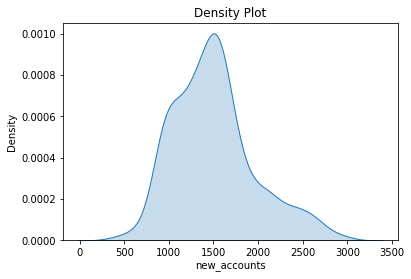

In [ ]:
sns.kdeplot(df[KPI_COL], label = KPI_COL, shade = True)
plt.xlabel(KPI_COL); plt.ylabel('Density'); plt.title('Density Plot');

Plot some features

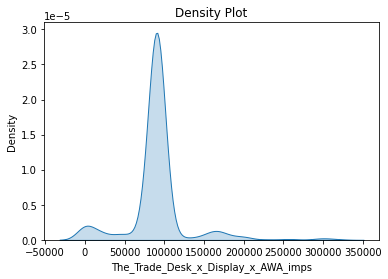

In [ ]:
sns.kdeplot(df[df.columns[1]], label = '', shade = True)
plt.xlabel(df.columns[1]); plt.ylabel('Density'); plt.title('Density Plot');

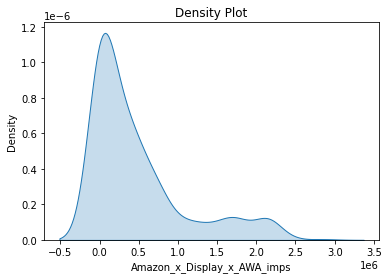

In [ ]:
sns.kdeplot(df[df.columns[2]], label = '', shade = True)
plt.xlabel(df.columns[2]); plt.ylabel('Density'); plt.title('Density Plot');

Look at relationship of individual features with target data

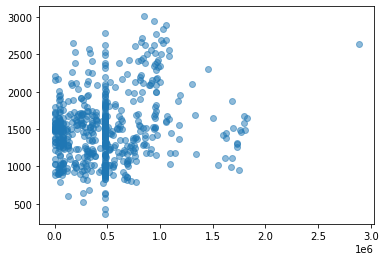

In [ ]:
plt.plot(df[df.columns[4]], data['new_accounts'],'o',alpha=0.5)
plt.show()

# Export data to sheets

In [ ]:
#@title Name data export sheet

# Naming for final data export
SHEET_NAME = 'model input data 8.17.21' #@param {type:"string"}
TAB_NAME = 'cleaned data' #@param {type:"string"}

In [ ]:
# create new spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.create(SHEET_NAME)

# generate link for file 
SHEET_URL = "https://docs.google.com/spreadsheets/d/"+sh.id
print("Sheet URL is " + SHEET_URL)



Sheet URL is https://docs.google.com/spreadsheets/d/1OU5aPno7LHl8EoOVTxiOOOOzDLDQOzqr-FaWCvlW8jA


In [ ]:
worksheet = sh.add_worksheet(title= TAB_NAME, rows=len(data), cols=len(data.columns))
set_with_dataframe(worksheet, data)